In [1]:
%load_ext autoreload
%autoreload 2

import nibabel as nib
import nilearn as nil
from nilearn import plotting, connectome, image, maskers
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import networkx as nx
from torch_geometric.data import Data
from networkx.convert_matrix import from_numpy_array
from torch_sparse import coalesce
from torch_geometric.utils import remove_self_loops
from tqdm import tqdm
import torch as torch
import re
from LCNAData import LCNAData
pd.set_option('display.max_rows', 20)

# Change this path to the project repository
current_dir = '/home/arashsm79/Playground/EPFL/epfl-ml-project2'
data_path = os.path.join(current_dir, 'data', 'dataset')
stuff_path = os.path.join(current_dir, 'data', 'dataset', 'OTHER_STUFF')
preproc_path = os.path.join(current_dir, 'data', 'gnn_data', 'preproc')
model_path = os.path.join(current_dir, 'gnn', 'model')

In [2]:
epi_template = nib.load(os.path.join(stuff_path, 'EPI_template.nii.gz'))
atlas_img = nib.load(os.path.join(stuff_path, 'EPI_template_2021_200um_parcellation_VZe_RL_thr.nii.gz'))
atlas_img_arr = nib.load(os.path.join(stuff_path, 'EPI_template_2021_200um_parcellation_VZe_RL_thr.nii.gz')).get_fdata()

# Visualizing Salient ROIs (68 Nodes)

In [3]:
nroi = 68
roi_scores = np.zeros(nroi)
batchsize = 32
kfold = 5

for fold in range(kfold):
    scores_dict = dict(np.load(os.path.join(model_path, f'scores-{fold}.npz')))
    s1_list = scores_dict['s1']
    p1_list = scores_dict['p1']
    original_index = dict(np.load(os.path.join(preproc_path, 'EPI_label_to_node_mapping.npz')))['epi_labels'][1:]
    n_graphs = s1_list.shape[0]
    ranking_score = np.arange(s1_list.shape[1])[::-1]

    for idx, p1 in enumerate(p1_list):
        mult = idx % batchsize
        p1 = p1 - mult*nroi
        roi_scores[p1] += ranking_score

roi_scores = (roi_scores - np.min(roi_scores)) / (np.max(roi_scores) - np.min(roi_scores))

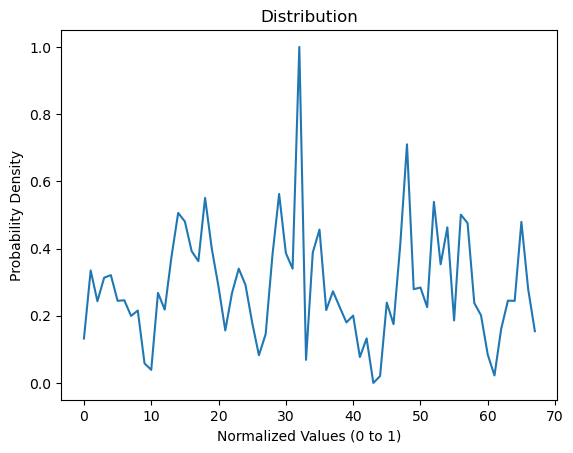

In [4]:
# Plotting the PDF
plt.plot(np.arange(len(roi_scores)), roi_scores)

# Adding labels and title
plt.xlabel('Normalized Values (0 to 1)')
plt.ylabel('Probability Density')
plt.title('Distribution')

# Display the plot
plt.show()

In [5]:
atlas_img_arr_map = atlas_img_arr.copy()

for idx, roi_score in enumerate(roi_scores):
    orig_label = original_index[idx]
    atlas_img_arr_map[atlas_img_arr_map == orig_label] = roi_score

for label in list(set(np.unique(atlas_img_arr)) - set(original_index)):
    atlas_img_arr_map[atlas_img_arr_map==label] = 0

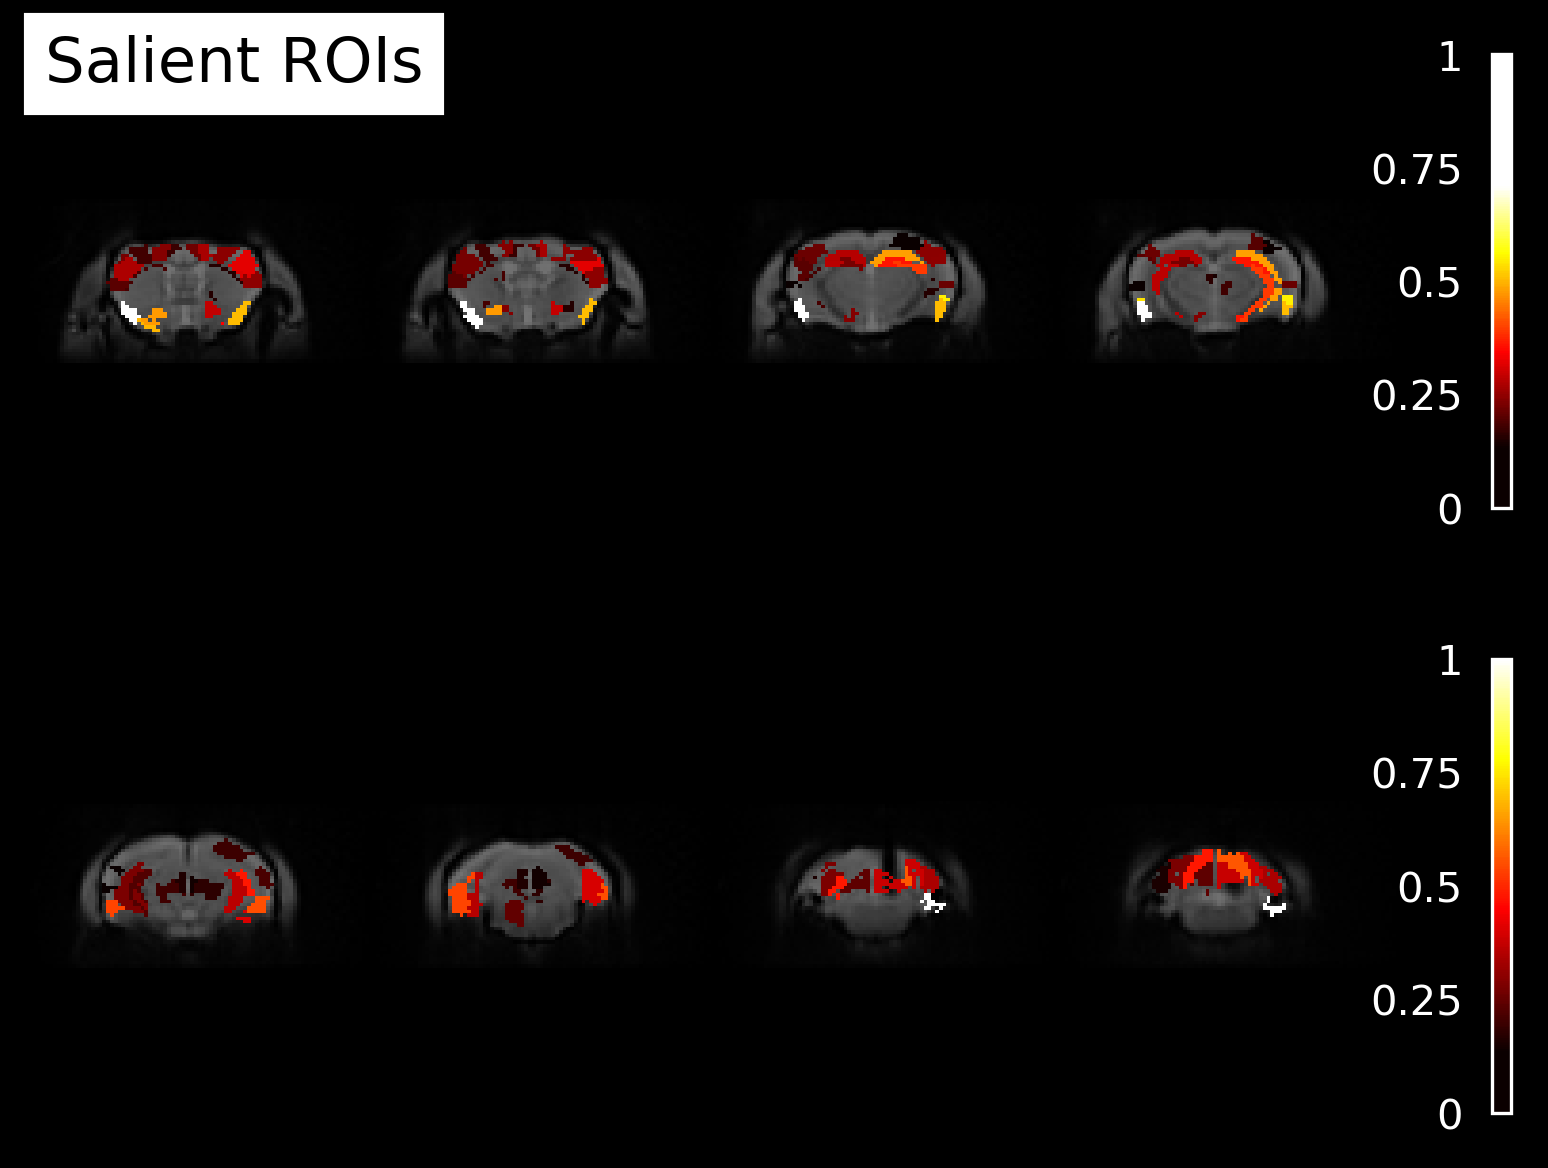

In [24]:
fig, axs = plt.subplots(2, 1)
fig.set_facecolor('#000000')
fig.set_dpi(300)
plotting.plot_img(
    epi_template,
    display_mode = 'z',
    cut_coords = [77,68,57,50],
    title="Salient ROIs",
    cmap="gray",
    black_bg=True,
    draw_cross = False,
    annotate = False,
    vmax=12,
    axes=axs[0]
).add_overlay(nib.Nifti1Image(atlas_img_arr_map, atlas_img.affine, atlas_img.header),cmap='black_red', cbar_vmin=0, cbar_vmax=1, colorbar=True, alpha=1.0, threshold=0.1)

plotting.plot_img(
    epi_template,
    display_mode = 'z',
    cut_coords = [42,32,19,15],
    cmap="gray",
    black_bg=True,
    draw_cross = False,
    annotate = False,
    vmax=12,
    axes=axs[1]
).add_overlay(nib.Nifti1Image(atlas_img_arr_map, atlas_img.affine, atlas_img.header),cmap='black_red', cbar_vmin=0, cbar_vmax=1,  colorbar=True, alpha=1.0, threshold=0.1)